# Project 2: Ames Housing Data and Kaggle Challenge
> By: Matthew Lio
---


Project notebook organisation:

- 01. EDA
- 02. Preprocessing and Feature Engineering
- 03. Model Tuning and Insights (current notebook)

# 03. Model Tuning and Insights
---

In this notebook, we will be training our model with all the features we have analysed and engineered from the previous 2 notebooks. The models we have chosen are:

- Dummy Regressor: A simple baseline model using mean
- Linear Regression: The linear approach
- Ridge Regression: A model that deals with multicollinearity
- Lasso regression: A type of linear regression using shrinkage

Prior to using the models, we will be using 2 popular scaler transformation methods to help shift and scale each feature. They are:

- StandardScaler
- PowerTransformer

A total of 8 combinations will be modeled (2 scalers x 4 regression models), and among them, the best performing one will be chosen as our production model.

Next, we will perform a feature selection technique using Lasso regression model. The best and worse performing features, as well as negatively correlated ones, will be analysed based on their coefficients. We will explore how they could answer our problem statement and how they could affect the results of our predictions. After selection, the model will be trained again to produce our production model.

Finally, our production model will be compared to our initial model; advantages and disadvantages will be weighed, RMSE scoring will be done via Kaggle.com, and final conclusions and recommendations will be drawn.

### Contents:
- [Library Imports](#Library-Imports)
- [Dataset Preprocessing](#Dataset-Preprocessing)
- [Functions for Modeling](#Functions-for-Modeling)
- [Regression Models (Using StandardScaler)](#Regression-Models-(Using-StandardScaler))
- [Regression Models (Using PowerTransformer)](#Regression-Models-(Using-PowerTransformer))
- [Model Performance Summary](#Model-Performance-Summary)
- [Residual Plot](#Residual-Plot)
- [Prediction Plot](#Prediction-Plot)
- [Production Model](#Production-Model)
- [Using Production Model and Kaggle Submission](#Using-Production-Model-and-Kaggle-Submission)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Library Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import patsy

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.dummy import DummyRegressor
from scipy.stats.mstats import winsorize

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Dataset Preprocessing

### Import preprocessed data

In [2]:
train = pd.read_csv("../datasets/train_cleaned.csv")

# remove unnamed column
train = train.iloc[:, 1:]

In [3]:
# function for dropping columns
def drop_col(df, cols_to_drop):
    df.drop(cols_to_drop, axis = 1, inplace = True)

### One-hot encoding

In [4]:
train_dummies = pd.get_dummies(train, drop_first = True)
train_dummies.shape

(2044, 38)

38 features after one-hot encoding.

### Train-test-split training data

In [5]:
X = train_dummies.loc[:, train_dummies.columns != 'saleprice']
y = train_dummies[['saleprice']]

print(X.shape)
print(y.shape)

# train test split
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
print(X_train.shape)
print(y_train.shape)

(2044, 37)
(2044, 1)
(1533, 37)
(1533, 1)


## Functions for Modeling

In [6]:
def rmse(y_test, y_pred):
    """Function to calculate rmse score"""
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [7]:
# function for easy display of all metric scores we are interested in
# local function, so need to separately fit model again for global usage later
def model_eval(model, X_train, X_val, y_train, y_val):
    
    """Function to fit and generate the train and test scores, RMSE, and cross-validation scores"""
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    
    print(f'{model}')
    print(f'Train Score (R^2): {model.score(X_train, y_train)}')
    print(f'Test Score (R^2): {model.score(X_val, y_val)}')
    print(f'RMSE Score: {rmse(y_val, pred)}')
    print('Cross Val Score (R^2):', cross_val_score(model, X_train, y_train, cv=10).mean())
    print('Cross Val Score (RMSE):', abs(cross_val_score(model, X_train, y_train, cv=10,
                                                         scoring='neg_root_mean_squared_error').mean()))
    print()

## Modeling Methods

A total of 8 methods will be explored.

- `StandardScaler` and `PowerTransformer` -> Scaling method divided into 2 groups
- `DummyRegressor`, `LinearRegression`, `Ridge` and `Lasso` -> 4 model methods

We will be using a function that gives us all the metric scores that we need.
1. Train Score (R^2): For train data. The coefficient of determination that measures the fit. How close the data are to the fitted model. Higher the score (closer to 1), the better the fit.
2. Test Score (R^2): For test data, same as above.
3. RMSE Score: Root Mean Square Error that tells us how spread out the residuals are, which translates to how accurate our model is. Lower the better.
4. Cross Val Score (R^2): Mean R2 value across all the cross-valuation scores
5. Cross Val Score (RMSE): RMSE value across all the cross-valuation scores

### Data Scaling

1. StandardScaler
2. PowerTransformer

In [8]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [9]:
pt = PowerTransformer()

X_train_pt = pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)

## Regression Models (Using StandardScaler)

- Dummy Regressor (baseline model)
- Linear regression
- Ridge regression
- Lasso regession

In [10]:
# baseline model using DummyRegressor()
model_eval(DummyRegressor(), X_train_ss, X_test_ss, y_train, y_test)

# Linear Regression
model_eval(LinearRegression(), X_train_ss, X_test_ss, y_train, y_test)

# Finding optimal value for Ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas = ridge_alphas, cv=10)
optimal_ridge.fit(X_train_ss, y_train);
# Ridge regression
model_eval(Ridge(alpha=optimal_ridge.alpha_), X_train_ss, X_test_ss, y_train, y_test)

# Finding optimal value for Lasso regression alpha using LassoCV
lasso_alphas = np.logspace(-5, 4, 500)
optimal_lasso = LassoCV(alphas = lasso_alphas, cv=10)
optimal_lasso.fit(X_train_ss, y_train);
# Lasso regression
model_eval(Lasso(alpha=optimal_lasso.alpha_), X_train_ss, X_test_ss, y_train, y_test)

DummyRegressor()
Train Score (R^2): 0.0
Test Score (R^2): -0.001349665520891552
RMSE Score: 78731.19547731965
Cross Val Score (R^2): -0.0034581436633626785
Cross Val Score (RMSE): 79386.67113240575

LinearRegression()
Train Score (R^2): 0.8803334892402699
Test Score (R^2): 0.8981525643033148
RMSE Score: 25108.976881796523
Cross Val Score (R^2): 0.8739426868554491
Cross Val Score (RMSE): 28103.583892607898

Ridge(alpha=32.17641750250737)
Train Score (R^2): 0.8801523895348339
Test Score (R^2): 0.8980217951635138
RMSE Score: 25125.091308187402
Cross Val Score (R^2): 0.8741880081875909
Cross Val Score (RMSE): 28078.60973987598

Lasso(alpha=293.0446976972144)
Train Score (R^2): 0.8798528423800462
Test Score (R^2): 0.8971621592566816
RMSE Score: 25230.76636379559
Cross Val Score (R^2): 0.8751652463467879
Cross Val Score (RMSE): 27970.956587815213



Looking at train and test R2 scores, all models show little over-fitting as there are very little variations between their training and test data.

The baseline model (dummy regressor) is the worse, producing extremely bad accuracy based on its very high mean RMSE score. This is to be expected as a baseline model always predicts the mean of a training data.

The best model here, after scaling with StandardScaler, is our linear regression model at a mean RMSE score of 25108, producing the best mean RMSE score after predicting the y values from test data split.

## Regression Models (Using PowerTransformer)

- Dummy Regressor (baseline model)
- Linear regression
- Ridge regression
- Lasso regession

In [11]:
# baseline model using DummyRegressor()
model_eval(DummyRegressor(), X_train_pt, X_test_pt, y_train, y_test)

# Linear regression
model_eval(LinearRegression(), X_train_pt, X_test_pt, y_train, y_test)

# Finding optimal value for Ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas = ridge_alphas, cv=10)
optimal_ridge.fit(X_train_pt, y_train);
# Ridge regression
model_eval(Ridge(alpha=optimal_ridge.alpha_), X_train_pt, X_test_pt, y_train, y_test)

# Finding optimal value for Lasso regression alpha using LassoCV
lasso_alphas = np.logspace(-5, 4, 500)
optimal_lasso = LassoCV(alphas = lasso_alphas, cv=10)
optimal_lasso.fit(X_train_pt, y_train);
# Lasso regression
model_eval(Lasso(alpha=optimal_lasso.alpha_), X_train_pt, X_test_pt, y_train, y_test)

DummyRegressor()
Train Score (R^2): 0.0
Test Score (R^2): -0.001349665520891552
RMSE Score: 78731.19547731965
Cross Val Score (R^2): -0.0034581436633626785
Cross Val Score (RMSE): 79386.67113240575

LinearRegression()
Train Score (R^2): 0.849056351037671
Test Score (R^2): 0.8693957506105109
RMSE Score: 28433.65051992697
Cross Val Score (R^2): 0.8405667707132576
Cross Val Score (RMSE): 31607.38244769312

Ridge(alpha=64.42363508721374)
Train Score (R^2): 0.8485603524060132
Test Score (R^2): 0.8688148388412337
RMSE Score: 28496.81506529698
Cross Val Score (R^2): 0.8412913363982666
Cross Val Score (RMSE): 31542.058112433348

Lasso(alpha=360.6734951574032)
Train Score (R^2): 0.8482727880177927
Test Score (R^2): 0.8696972696115514
RMSE Score: 28400.809935367994
Cross Val Score (R^2): 0.8420179937243832
Cross Val Score (RMSE): 31469.82909949772



After scaling with PowerTransformer, all models show little over-fitting as well. As expected, the baseline model performed the worse.

The best model here is our lasso model, producing a mean RMSE score of 28400.

## Model Performance Summary

| Model 	| R2      	| RMSE    	|
|-------	|---------	|---------	|
|DummyRegressor (StandardScaler)|0.0|78731.19|
|DummyRegressor (PowerTransformer)| 0.0|78731.19|
|LinearRegression (StandardScaler)|0.88033|25108.97|
|LinearRegression (PowerTransformer)|0.84905|28433.65|
|Ridge (StandardScaler)|0.88015|25125.09|
|Ridge (PowerTransformer)|0.84856|28496.81|
|Lasso (StandardScaler)|0.87985|25230.76|
|Lasso (PowerTransformer)|0.84827|28400.80|

Four different models were evaluated on train data, with the features scaled either by `StandardScaler` or `PowerTransformer`, giving us a total of 8 methods. The above table summarizes all the results for train R2 and mean RMSE scores. Train R2 will tell us how well our train data fit our model, and mean RMSE will tell us the accuracy of our model after predicting y values from test data split.

From them, LinearRegression with features scaled by `StandardScaler` performed the best with the highest R2 (0.88033) and lowest RMSE (25108.97) scores. This could be because a linear regression line is not bias towards any of the features that we have chosen. Also, the scaling of the features, as well as when we winsorize some of the columns, might have helped with a better fit, thus increasing the prediction accuracy.

## Residual Plot

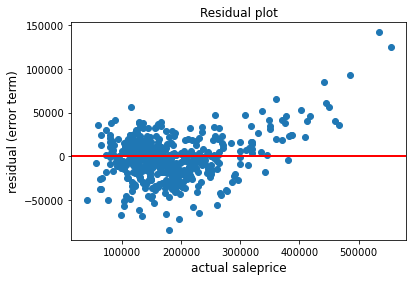

In [12]:
lr = LinearRegression()
lr.fit(X_train_ss, y_train)
y_pred = lr.predict(X_test_ss)

# find residuals
resid = y_test - y_pred
# plot residuals
plt.scatter(y_test, resid)
plt.axhline(0, linestyle='-', color='r', linewidth = 2)
plt.title('Residual plot')
plt.ylabel('residual (error term)', fontsize=12)
plt.xlabel('actual saleprice', fontsize=12)
plt.show()

One assumption of linear regression is homoscedasticity. Homoscedasticity in a model means that the error is constant along the values of the dependent variable (i.e. saleprice). Looking at the residual plot above, it is mostly so with our linear regression model, only at very high sale prices.

## Prediction Plot

In [13]:
y_test_arr = y_test['saleprice'].ravel()

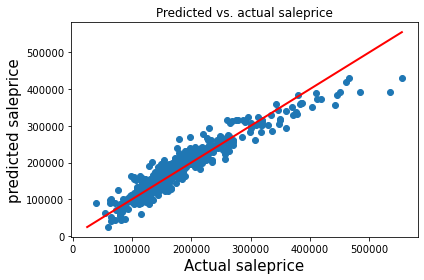

In [14]:
plt.scatter(y_test, y_pred)
p1 = max(max(y_test_arr), max(y_pred))
p2 = min(min(y_test_arr), min(y_pred))
plt.plot([p1, p2], [p1, p2], color = 'red', linewidth = 2)
plt.title('Predicted vs. actual saleprice')
plt.xlabel('Actual saleprice', fontsize=15)
plt.ylabel('predicted saleprice', fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.savefig('../images/3-1-predictionplot.jpg')
plt.show()

Our best model performed reasonably well for its prediction, except for higher sale prices, where it deviates a bit, as shown by the red line.

## Production Model

After knowing which of our model is the best performing, we now need to do feature selection with lasso regression model.

Lasso regression model provides this ability to produce the coefficients of our features, letting us know the ones that affected the prediction of the model the most. We can even apply this technique in a ranked manner for a clear visual.

Feature selection will let us limit the number of features, thus reducing the noise. Only the features with the highest coefficient will be selected for our final production model.

### Feature Selection

In [15]:
train_dummies.loc[:, train_dummies.columns != 'saleprice'].columns.tolist();

In [16]:
lasso = Lasso()
lasso.fit(X_train_ss, y_train)
y_pred = lasso.predict(X_test_ss)

features = train_dummies.loc[:, train_dummies.columns != 'saleprice'].columns.tolist()
lasso_df = pd.DataFrame({'Feature': features,
                         'Coef': lasso.coef_,
                         'Abs Coef': abs(lasso.coef_)})
lasso_df = lasso_df.sort_values(by='Abs Coef', ascending = False).reset_index(drop=True)
lasso_df

,Feature,Coef,Abs Coef
0,gr_liv_area,26442.475440,26442.475440
1,overall_qual,13806.951825,13806.951825
2,total_bsmt_sf,11235.386428,11235.386428
3,exter_qual,8318.171748,8318.171748
4,lot_area,7780.658024,7780.658024
5,neighborhood,6773.247420,6773.247420
6,kitchen_qual,6750.080679,6750.080679
7,garage_area,6210.841857,6210.841857
8,bsmt_exposure,6198.768469,6198.768469
9,functional,4382.939053,4382.939053


The above table shows us the coefficients of the features, ranked from most affecting to least affecting.

From the coefficients, some of the most important features that affect the model and predictions the most would be the size features, including living area, basement and lot area. Quality of different parts of the houses also play a huge part in predicting the sale prices.

We will only include the top 25 in our production model.

In [17]:
features = lasso_df.iloc[:25]
features

,Feature,Coef,Abs Coef
0,gr_liv_area,26442.475440,26442.475440
1,overall_qual,13806.951825,13806.951825
2,total_bsmt_sf,11235.386428,11235.386428
3,exter_qual,8318.171748,8318.171748
4,lot_area,7780.658024,7780.658024
5,neighborhood,6773.247420,6773.247420
6,kitchen_qual,6750.080679,6750.080679
7,garage_area,6210.841857,6210.841857
8,bsmt_exposure,6198.768469,6198.768469
9,functional,4382.939053,4382.939053


In [18]:
features = features['Feature'].tolist()

### Using selected features on final model

In [19]:
X = train_dummies[features]
y = train['saleprice']

print(X.shape)
print(y.shape)

# train test split
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
print(X_train.shape)
print(y_train.shape)

(2044, 25)
(2044,)
(1533, 25)
(1533,)


In [20]:
# using StandardScaler, the scaling method that gave us a better result
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

### Production model performance

In [21]:
model_eval(LinearRegression(), X_train_ss, X_test_ss, y_train, y_test)

LinearRegression()
Train Score (R^2): 0.8801522578537471
Test Score (R^2): 0.8973942087196577
RMSE Score: 25202.284181328872
Cross Val Score (R^2): 0.8760885990414946
Cross Val Score (RMSE): 27864.869299764978



R2 score: 0.88015

RMSE score: 25202.28

From the scores from our production model, we can see that there is very little difference with the initial model that included all features. That is good. Our production model maintains almost the same fit after training, and the prediction also scored similarly.

Even though by reducing the noise, we also lower the accuracy, we think that it is the worth the trade-off. Our model is slightly more interpretable, and for a reduction of 12 features, the RMSE score is only higher by about 90.

The advantage of using a Linear Regression model is such that the regression line does not overfit into any inputs, thus not bias to any features. This would make our model highly adaptable to new data, and still make accurate predictions.

## Using Production Model and Kaggle Submission

In [22]:
test = pd.read_csv("../datasets/test_cleaned.csv")

# remove unnamed column
test = test.iloc[:, 1:]
test

,id,lot_frontage,lot_area,lot_shape,neighborhood,overall_qual,mas_vnr_area,exter_qual,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,total_bsmt_sf,heating_qc,electrical,gr_liv_area,bsmt_full_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,functional,fireplaces,fireplace_qu,garage_finish,garage_area,garage_qual,paved_drive,wood_deck_sf,total_porch_area,age_sold
0,2658,69.000000,9142,0,3,6,0.0,3,Stone,2.0,3.0,1.0,1.0,1020,4,1.0,1928,0,2,0,4,2,2,7,0,0.0,1.0,440,1.0,2,0,172,96.0
1,2718,73.361611,9662,1,8,5,0.0,3,CBlock,4.0,3.0,1.0,1.0,1967,3,4.0,1967,0,2,0,6,2,3,7,0,0.0,3.0,580,3.0,2,170,0,29.0
2,2414,58.000000,17104,1,15,7,0.0,4,PConc,4.0,4.0,3.0,6.0,654,5,4.0,1496,1,2,1,3,1,4,7,1,4.0,2.0,426,3.0,2,100,24,0.0
3,1989,60.000000,8520,0,3,5,0.0,4,CBlock,3.0,3.0,1.0,1.0,968,3,4.0,968,0,1,0,2,1,3,7,0,0.0,1.0,480,2.0,0,0,184,84.0
4,625,73.193218,9500,1,11,6,247.0,3,CBlock,4.0,3.0,1.0,4.0,1394,4,4.0,1394,1,1,1,3,1,3,7,2,4.0,2.0,514,3.0,2,0,261,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,80.000000,8000,0,16,6,0.0,3,CBlock,3.0,3.0,1.0,5.0,1084,3,4.0,1877,1,2,1,4,1,3,7,1,3.0,1.0,488,3.0,2,0,96,33.0
874,1234,90.000000,14670,0,11,6,410.0,4,CBlock,3.0,3.0,1.0,4.0,1104,5,4.0,1988,0,2,1,4,1,4,7,1,4.0,2.0,480,3.0,2,0,230,42.0
875,1373,55.000000,8250,0,8,5,0.0,3,CBlock,3.0,3.0,1.0,4.0,952,5,4.0,1211,0,1,0,3,1,3,7,1,3.0,1.0,322,3.0,2,0,63,40.0
876,1672,60.000000,9000,0,11,4,0.0,3,PConc,3.0,3.0,1.0,5.0,864,3,4.0,864,0,1,0,3,1,3,7,0,0.0,1.0,528,3.0,2,0,0,36.0


In [23]:
test_dummies = pd.get_dummies(test, drop_first = True)
test_dummies.shape

(878, 37)

In [24]:
X = test_dummies[features]
X

,gr_liv_area,overall_qual,total_bsmt_sf,exter_qual,lot_area,neighborhood,kitchen_qual,garage_area,bsmt_exposure,functional,bsmt_full_bath,bsmt_cond,kitchen_abvgr,foundation_Slab,bsmt_qual,bedroom_abvgr,fireplace_qu,heating_qc,mas_vnr_area,bsmtfin_type_1,garage_qual,total_porch_area,wood_deck_sf,age_sold,paved_drive
0,1928,6,1020,3,9142,3,2,440,1.0,7,0,3.0,2,0,2.0,4,0.0,4,0.0,1.0,1.0,172,0,96.0,2
1,1967,5,1967,3,9662,8,3,580,1.0,7,0,3.0,2,0,4.0,6,0.0,3,0.0,1.0,3.0,0,170,29.0,2
2,1496,7,654,4,17104,15,4,426,3.0,7,1,4.0,1,0,4.0,3,4.0,5,0.0,6.0,3.0,24,100,0.0,2
3,968,5,968,4,8520,3,3,480,1.0,7,0,3.0,1,0,3.0,2,0.0,3,0.0,1.0,2.0,184,0,84.0,0
4,1394,6,1394,3,9500,11,3,514,1.0,7,1,3.0,1,0,4.0,3,4.0,4,247.0,4.0,3.0,261,0,46.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1877,6,1084,3,8000,16,3,488,1.0,7,1,3.0,1,0,3.0,4,3.0,3,0.0,5.0,3.0,96,0,33.0,2
874,1988,6,1104,4,14670,11,4,480,1.0,7,0,3.0,1,0,3.0,4,4.0,5,410.0,4.0,3.0,230,0,42.0,2
875,1211,5,952,3,8250,8,3,322,1.0,7,0,3.0,1,0,3.0,3,3.0,5,0.0,4.0,3.0,63,0,40.0,2
876,864,4,864,3,9000,11,3,528,1.0,7,0,3.0,1,0,3.0,3,0.0,3,0.0,5.0,3.0,0,0,36.0,2


In [25]:
ss = StandardScaler()
Xss = ss.fit_transform(X)

lr = LinearRegression()
lr.fit(X_train_ss, y_train)
y_pred = lr.predict(Xss)

In [26]:
y_pred

array([135974.93915864, 160704.88162718, 213834.805021  , 122793.2811668 ,
       185174.01575456,  73973.69449045,  93088.36440386, 155792.5030323 ,
       208260.55226446, 152564.42714903, 178895.59499066, 118538.39723254,
       165947.49078845, 249485.52470607, 164649.65202181, 108600.96567733,
       137742.98195782, 121577.80258944, 178847.85003694, 211253.46080502,
       148600.20109519, 127304.2959549 , 222542.84578176, 190162.25929822,
       188082.18573594, 115929.66760189, 144787.32790021, 155404.81497468,
       170998.19586704,  41144.52228649, 101596.53421196, 106276.42090399,
       270007.93921355, 154325.51388101, 236800.93728331, 169829.790678  ,
       118369.23570996,  77587.22733204, 123747.71641803, 208033.38757396,
       181446.19278801, 210348.39175578, 155005.13998228, 170408.29456076,
       252726.77489574,  89653.80993725, 240786.02306895, 118374.69108278,
       122809.8520318 , 117455.61291852, 119497.85661992, 219125.07554184,
       262445.69189396, 1

In [27]:
# load original test set
original_test = pd.read_csv('../datasets/test.csv')
# get the ID column, add new col called saleprice
submission = original_test[['Id']]
submission['SalePrice'] = y_pred

In [28]:
# export csv for submission in to Kaggle
submission.to_csv('../datasets/kaggle_submission.csv', index = False)

### Submission link and Kaggle scores

https://www.kaggle.com/c/dsi-us-11-project-2-regression-challenge/submissions

- Private Score: 24362.71291
- Public Score: 31980.27022

## Conclusion and Recommendations

In [29]:
features = lasso_df.iloc[:25]
features

,Feature,Coef,Abs Coef
0,gr_liv_area,26442.475440,26442.475440
1,overall_qual,13806.951825,13806.951825
2,total_bsmt_sf,11235.386428,11235.386428
3,exter_qual,8318.171748,8318.171748
4,lot_area,7780.658024,7780.658024
5,neighborhood,6773.247420,6773.247420
6,kitchen_qual,6750.080679,6750.080679
7,garage_area,6210.841857,6210.841857
8,bsmt_exposure,6198.768469,6198.768469
9,functional,4382.939053,4382.939053


Our Linear Regression model, scaled with Standard Scaler, had the best predictive performance on housing sale price in Ames, out-performing Ridge and Lasso regression models. We also used Lasso regression to help us feature select the features that affect sale price the most.

From the above coefficient summary table, the top 5 features that determine the sale price are the size (living, basement and total lot area) and quality (overall and external quality) of the house. Neighborhood of the house comes in at a close 6th place. Other important features that affect sale prices include garage and porches areas, and quality of kitchen, basement and garage. In order to maintain the value of a house, quality is very important.

For home-seekers with specific budget, this model tells them what features they need to consider to be able to afford a house. Houses that are smaller in living, basement and lot areas might be ideal for them. They might also need to settle for an older house, at a less desirable neighborhood. They could also look at houses with lesser masonry veneer area.

For investors looking to invest in a house, they should take a look at the top 3 most desirable neighborhoods like Stone Brook, Northridge heights and Northridge. They have the potential to sell for high prices. In order to buy for lower prices and sell high, they could look for houses with little to no masonry veneer, and small porch areas. They could then improve the value of their house by installing those features themselves, installing masonry veneers and building porches. They should also consider selling their house as soon as they can, as the value decreases the older a house is. Lastly, they should maintain the quality of their house as much as possible.

This model is not without its disadvantages. As the model was developed based on data on houses sold between 2006 - 2010 in Ames, the small time frame limits the annual patterns in sale price that could arise from external factors, like economy or policy changes. The sale prices most likely were not adjusted based on inflation, which could have given us a variation in price through the years. Right now at the beginning of 2022, after 12 years, this model may not be as accurate present day. To improve the applicability of the model, we need to consider more data from a wider time frame.

In reality, house prices are difficult to predict as it may also be affected by factors hard to include in a dataset, for example like buyer's or seller's psychology, how everyone place different emphasis on different features, and also the economic climate. This model therefore does not give perfect predictions, but should rather be used as just a guide for a more informed decision.